In [ ]:
!pip3 install --upgrade gym
# !pip3 install pytorch
!pip3 install gym.wrappers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827623 sha256=9c5ded084923eba163f82bfd01a18e2ebf5cdc0691cd9f6e61c2bbf376d63676
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for gym.wrappers: filename=gym_wrappers-0.1.0

In [ ]:
import gym
from gym.spaces import Box
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from collections import deque
from  torch.autograd import Variable

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


In [ ]:


class CartPoleOptimalControlEnv(gym.Env):
    """Custom Gym environment for cart-pole system with optimal control."""

    def __init__(self):
        """
        Initialize the environment parameters and action space.
        """
        self.M = 40.0  # Mass of the cart (kg)
        self.mp = 2.0  # Mass of the pole (kg)
        self.L = 0.75  # Length of the pole (m)
        self.g = 10  # Acceleration due to gravity (m/s^2)

        # State space: [cart position (x), cart velocity (x_dot), pole angle (theta), pole angular velocity (theta_dot)]
        POSITIVE_INF = float('inf')  # Define a constant for positive infinity
        NEGATIVE_INF = -float('inf')  # Define a constant for negative infinity
        self.state_space = Box(low=np.array([-1000000, NEGATIVE_INF, -np.pi/12, NEGATIVE_INF]),
                                high=np.array([100000, POSITIVE_INF, np.pi/12, POSITIVE_INF]))

        # Action space: Force applied to the cart (Fx)
        # self.action_space = Box(low=-10.0, high=10.0)  # Force limits in Newtons
        self.action_space = gym.spaces.Discrete(2)

        self.threshold = 195

        # Initial state
        self.reset()

        # Time step (seconds)
        self.dt = 0.2
    def step(self, action):
        """
        Performs one simulation step of the cart-pole system based on the given action.

        Args:
            action: Force applied to the cart (Fx)

        Returns:
            observation (ndarray): The next state of the system.
            reward (float): The reward for the current step.
            done (bool): Whether the episode is finished.
            info (dict): Additional information about the episode.
        """

        # Check if action is within bounds
        if action < 0 or action >= self.action_space.n:
          raise ValueError("Action ({}) out of bounds".format(action))

        # Convert discrete action to continuous force based on action space
        F_x = -1.0 if action == 0 else action

        # Update time step
        self.t += self.dt

        # Equations of motion
        # F_x = action
        tau = (self.M * self.L * self.theta_dot**2 * np.sin(self.theta) + self.M * self.g * self.L * np.cos(self.theta) * np.sin(self.theta)) / \
              (self.M + self.mp * np.sin(self.theta)**2)
        x_ddot = (F_x - self.mp * self.L * (self.theta_dot**2) * np.sin(self.theta)+ self.mp * self.g * (np.sin(self.theta)*np.cos(self.theta))) / \
              (self.M + self.mp * np.sin(self.theta)**2)
        theta_ddot = ((F_x - self.mp * self.L * (self.theta_dot**2) * np.sin(self.theta)) * np.cos(self.theta) + (self.M + self.mp) * self.g * np.sin(self.theta)) / \
              (self.M + self.mp * np.sin(self.theta)**2)*self.L




        # Update state using numerical integration
        self.x_dot += x_ddot * self.dt
        self.x += self.x_dot * self.dt
        self.theta_dot += theta_ddot * self.dt
        self.theta += self.theta_dot * self.dt

        # Terminal conditions
        done = bool(
            self.x < self.state_space.low[0] or
            self.x > self.state_space.high[0] or
            np.abs(self.theta) > np.pi/2 or
            self.t >= 100  # Maximum episode length
        )

        # Reward function: Encourage staying close to the center and upright position
        # reward = -1
        reward =  - 100*np.abs(self.theta)*np.abs(self.theta) - 2*np.abs(self.theta_dot)*np.abs(self.theta_dot)
        # reward =  - np.abs(self.theta) - np.abs(self.x) - np.abs(self.theta_dot) - np.abs(self.x_dot)
        # reward =  - np.abs(self.theta) - np.abs(self.x)
        # reward = np.cos(self.theta)


        # Observation (state)
        observation = np.array([self.x, self.x_dot, self.theta, self.theta_dot])

        return observation, reward, done, {}

    def reset(self):
        """
        Resets the environment to the initial state with some randomness.

        Returns:
            observation (ndarray): The initial state of the system with random initial angle.
        """
        self.x = 0.0
        self.x_dot = 0.0
        # Randomize initial angle within a defined range
        self.theta = np.random.uniform(low=-np.pi/12, high=np.pi/12)  # Adjust range as needed
        self.theta_dot = 0.0
        self.t = 0.0
        return np.array([self.x, self.x_dot, self.theta, self.theta_dot])




In [ ]:
import random
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, batch):
        self.memory.append(batch)
        if len(self.memory) > self.capacity:
            del self.memory[0]


    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
import torch
import torch.nn as nn

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim) -> None:
        """DQN Network

        Args:
            input_dim (int): `state` dimension.
                `state` is 2-D tensor of shape (n, input_dim)
            output_dim (int): Number of actions.
                Q_value is 2-D tensor of shape (n, output_dim)
            hidden_dim (int): Hidden dimension in fc layer
        """

        super(QNetwork, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
#            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.PReLU()
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.PReLU()
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.PReLU()
        )

        self.final = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Returns a Q_value

        Args:
            x (torch.Tensor): `State` 2-D tensor of shape (n, input_dim)

        Returns:
            torch.Tensor: Q_value, 2-D tensor of shape (n, output_dim)
        """

        ## print('type(x) of forward:', type(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.final(x)

        return x



In [ ]:
import torch
import torch.optim as optim
import random
from  torch.autograd import Variable

BATCH_SIZE = 64
LEARNING_RATE = 0.001

class Agent(object):

    def __init__(self, n_states, n_actions, hidden_dim):
        """Agent class that choose action and train

        Args:
            n_states (int): input dimension
            n_actions (int): output dimension
            hidden_dim (int): hidden dimension
        """

        self.q_local = QNetwork(n_states, n_actions, hidden_dim=16).to(device)
        self.q_target = QNetwork(n_states, n_actions, hidden_dim=16).to(device)

        self.mse_loss = torch.nn.MSELoss()
        self.optim = optim.Adam(self.q_local.parameters(), lr=LEARNING_RATE)

        self.n_states = n_states
        self.n_actions = n_actions

        #  ReplayMemory: trajectory is saved here
        self.replay_memory = ReplayMemory(10000)


    def get_action(self, state, eps, check_eps=True):
        """Returns an action

        Args:
            state : 2-D tensor of shape (n, input_dim)
            eps (float): eps-greedy for exploration

        Returns: int: action index
        """
        global steps_done
        sample = random.random()

        if check_eps==False or sample > eps:
           with torch.no_grad():
               # t.max(1) will return largest column value of each row.
               # second column on max result is index of where max element was
               # found, so we pick action with the larger expected reward.
               return self.q_local(Variable(state).type(FloatTensor)).data.max(1)[1].view(1, 1)
        else:
           ## return LongTensor([[random.randrange(2)]])
           return torch.tensor([[random.randrange(self.n_actions)]], device=device)


    def learn(self, experiences, gamma):
        """Prepare minibatch and train them

        Args:
        experiences (List[Transition]): batch of `Transition`
        gamma (float): Discount rate of Q_target
        """

        if len(self.replay_memory.memory) < BATCH_SIZE:
            return;

        transitions = self.replay_memory.sample(BATCH_SIZE)

        batch = Transition(*zip(*transitions))

        # print(batch)
        states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)
        next_states = torch.cat(batch.next_state)
        dones = torch.cat(batch.done)


        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to newtork q_local (current estimate)
        Q_expected = self.q_local(states).gather(1, actions)

        Q_targets_next = self.q_target(next_states).detach().max(1)[0]

        Q_targets = rewards + (gamma * Q_targets_next * (1-dones))

        #self.q_local.train(mode=True)
        self.optim.zero_grad()
        loss = self.mse_loss(Q_expected, Q_targets.unsqueeze(1))
        loss.backward()
        self.optim.step()



In [ ]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")

BATCH_SIZE = 64
TAU = 0.005 # 1e-3   # for soft update of target parameters
gamma = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE = 10
hidden_dim = 16

num_episodes = 100
print_every = 10
# hidden_dim = 16 ## 64 ## 16
min_eps = 0.01
max_eps_episode = 50

env = CartPoleOptimalControlEnv()
# env = gym.make('CartPole-v0')
# env = gym.wrappers.Monitor(env, directory="monitors", force=True)
env.reset()

print(env.__dict__)
space_dim =  env.state_space.shape[0] # n_spaces
action_dim = 2 # n_actions
print('input_dim: ', space_dim, ', output_dim: ', action_dim, ', hidden_dim: ', hidden_dim)

threshold = env.threshold
print('threshold: ', threshold)

# space_dim =  env.observation_space.shape[0] # n_spaces
# action_dim = env.action_space.n # n_actions
# print('input_dim: ', space_dim, ', output_dim: ', action_dim, ', hidden_dim: ', hidden_dim)

# threshold = env.spec.reward_threshold
# print('threshold: ', threshold)

agent = Agent(space_dim, action_dim, hidden_dim)


def epsilon_annealing(i_epsiode, max_episode, min_eps: float):
    ##  if i_epsiode --> max_episode, ret_eps --> min_eps
    ##  if i_epsiode --> 1, ret_eps --> 1
    slope = (min_eps - 1.0) / max_episode
    ret_eps = max(slope * i_epsiode + 1.0, min_eps)
    return ret_eps

def save(directory, filename):
    torch.save(agent.q_local.state_dict(), '%s/%s_local.pth' % (directory, filename))
    torch.save(agent.q_target.state_dict(), '%s/%s_target.pth' % (directory, filename))


{'M': 40.0, 'mp': 2.0, 'L': 0.75, 'g': 10, 'state_space': Box([-1.000000e+06          -inf -2.617994e-01          -inf], [1.000000e+05          inf 2.617994e-01          inf], (4,), float32), 'action_space': Discrete(2), 'threshold': 195, 'x': 0.0, 'x_dot': 0.0, 'theta': 0.08610197921304535, 'theta_dot': 0.0, 't': 0.0, 'dt': 0.2}
input_dim:  4 , output_dim:  2 , hidden_dim:  16
threshold:  195


In [ ]:
def run_episode(env, agent, eps):
    """Play an epsiode and train

    Args:
        env (gym.Env): gym environment (CartPole-v0)
        agent (Agent): agent will train and get action
        eps (float): eps-greedy for exploration

    Returns:
        int: reward earned in this episode
    """

    state = env.reset()
    done = False
    total_reward = 0

    # noise = np.random.normal(scale=0.1, size=state.shape)  # Adjust noise scale as needed
    # state = state + noise

    # state = np.array(state[0])
    while not done:

        action = agent.get_action(FloatTensor([state]) , eps)
        # next_state, reward, done, _ = env.step(action.item())[0]
        # print(env.step(action.item()))
        next_state, reward, done, _ = env.step(action.item())

        total_reward += reward

        if done:
            reward = -1

        # Store the transition in memory
        agent.replay_memory.push(
                (FloatTensor([state]),
                 action, # action is already a tensor
                 FloatTensor([reward]),
                 FloatTensor([next_state]),
                 FloatTensor([done])))


        if len(agent.replay_memory) > BATCH_SIZE:

            batch = agent.replay_memory.sample(BATCH_SIZE)

            agent.learn(batch, gamma)

        state = next_state


    return total_reward


In [ ]:

def train():

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    time_start = time.time()

    for i_episode in range(num_episodes):
        # print(i_episode)
        eps = epsilon_annealing(i_episode, max_eps_episode, min_eps)
        score = run_episode(env, agent, eps)

        # print(score)
        scores_deque.append(score)
        scores_array.append(score)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        dt = (int)(time.time() - time_start)

        if i_episode % print_every == 0 and i_episode > 0:
            print('Episode: {:5} Score: {:5}  Avg.Score: {:.2f}, eps-greedy: {:5.2f} Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, score, avg_score, eps, dt//3600, dt%3600//60, dt%60))

        if len(scores_deque) == scores_deque.maxlen:
            ### 195.0: for cartpole-v0 and 475 for v1
            if np.mean(scores_deque) >= threshold:
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break


        if i_episode % TARGET_UPDATE == 0:
            agent.q_target.load_state_dict(agent.q_local.state_dict())

    return scores_array, avg_scores_array

scores, avg_scores = train()

<ipython-input-8-dd4c3257c724>:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  action = agent.get_action(FloatTensor([state]) , eps)


Episode:    10 Score: -596.4366298672263  Avg.Score: -645.64, eps-greedy:  0.80 Time: 00:00:00
Episode:    20 Score: -851.9369845873564  Avg.Score: -677.72, eps-greedy:  0.60 Time: 00:00:00
Episode:    30 Score: -447.4571469150852  Avg.Score: -656.79, eps-greedy:  0.41 Time: 00:00:00
Episode:    40 Score: -1076.7745604946867  Avg.Score: -677.53, eps-greedy:  0.21 Time: 00:00:00
Episode:    50 Score: -625.2597274221273  Avg.Score: -690.95, eps-greedy:  0.01 Time: 00:00:01
Episode:    60 Score: -560.4646984754252  Avg.Score: -686.39, eps-greedy:  0.01 Time: 00:00:01
Episode:    70 Score: -787.1041375505187  Avg.Score: -680.06, eps-greedy:  0.01 Time: 00:00:01
Episode:    80 Score: -425.73072373142713  Avg.Score: -680.64, eps-greedy:  0.01 Time: 00:00:01
Episode:    90 Score: -931.6409182393907  Avg.Score: -685.35, eps-greedy:  0.01 Time: 00:00:01


length of scores:  100 , len of avg_scores:  100


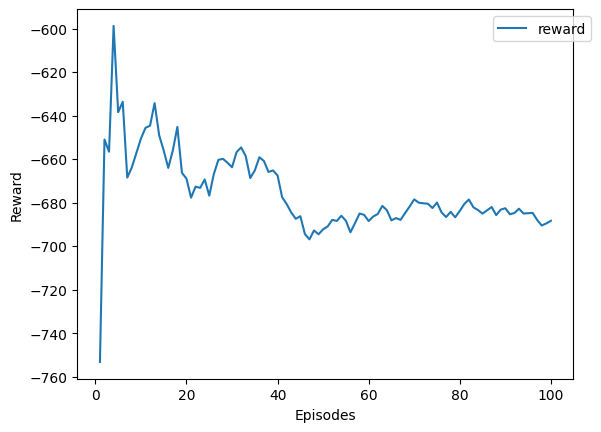

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), avg_scores, label="reward")
# plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Reward')
plt.xlabel('Episodes')
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate(env, policy_model,angle):
  rewards = []
  control_inputs = []
  states = []
  for _ in range(1):

    state = env.reset()
    state[2]=angle
    episode_rewards = []
    episode_control_inputs = []
    episode_states = []
    done = False
    itr = 0
    while not done:
        itr += 1
        eps = epsilon_annealing(itr, max_eps_episode, min_eps)
        action = policy_model.get_action(FloatTensor([state]) , eps)
        next_state, reward, done, _ = env.step(action.item())

        episode_rewards.append(reward)
        episode_control_inputs.append(action.item())
        episode_states.append(state)
        state = next_state

    rewards.append(sum(episode_rewards))
    control_inputs.append(np.array(episode_control_inputs))
    states.append(np.array(episode_states))
  return rewards, control_inputs, states


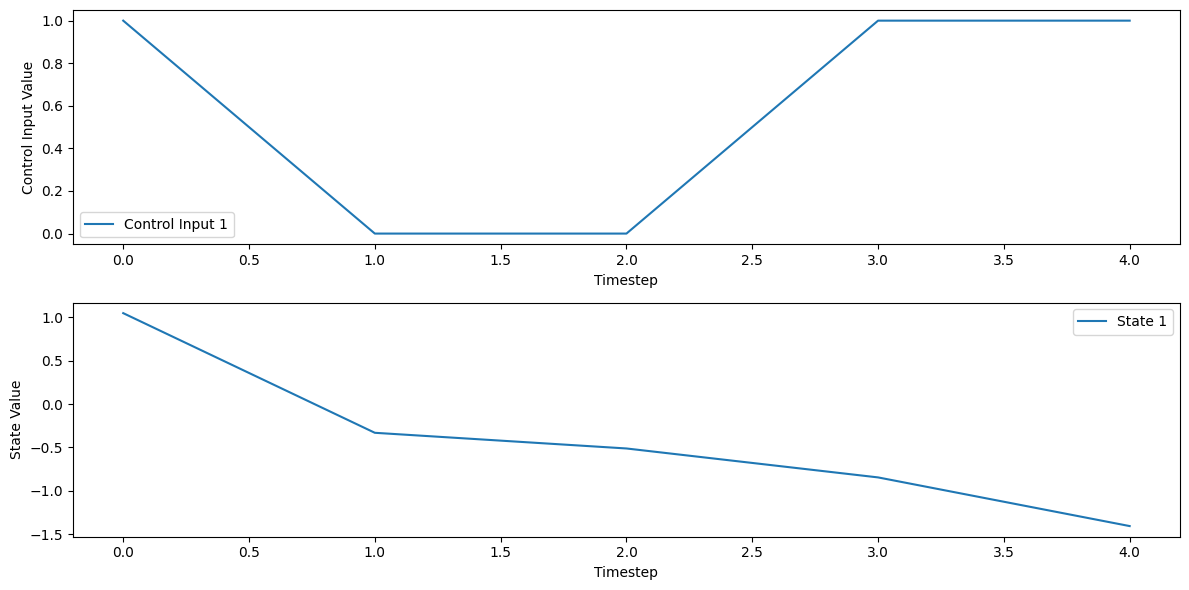

In [ ]:
rewards, control_inputs, states = evaluate(env, agent,1.0472)
# print(episode_ctrl_inputs)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]

episode_states = states[0]
plt.figure(figsize=(12, 6))


# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

# # Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

plt.tight_layout()
plt.show()


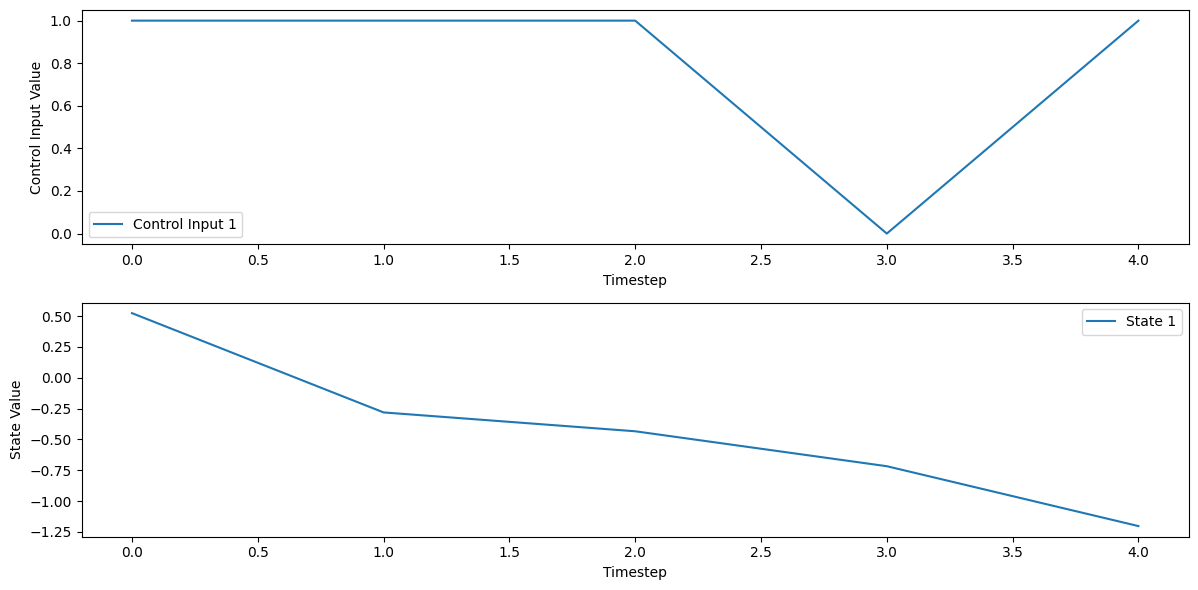

In [ ]:
rewards, control_inputs, states = evaluate(env, agent,0.5236)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))

# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()


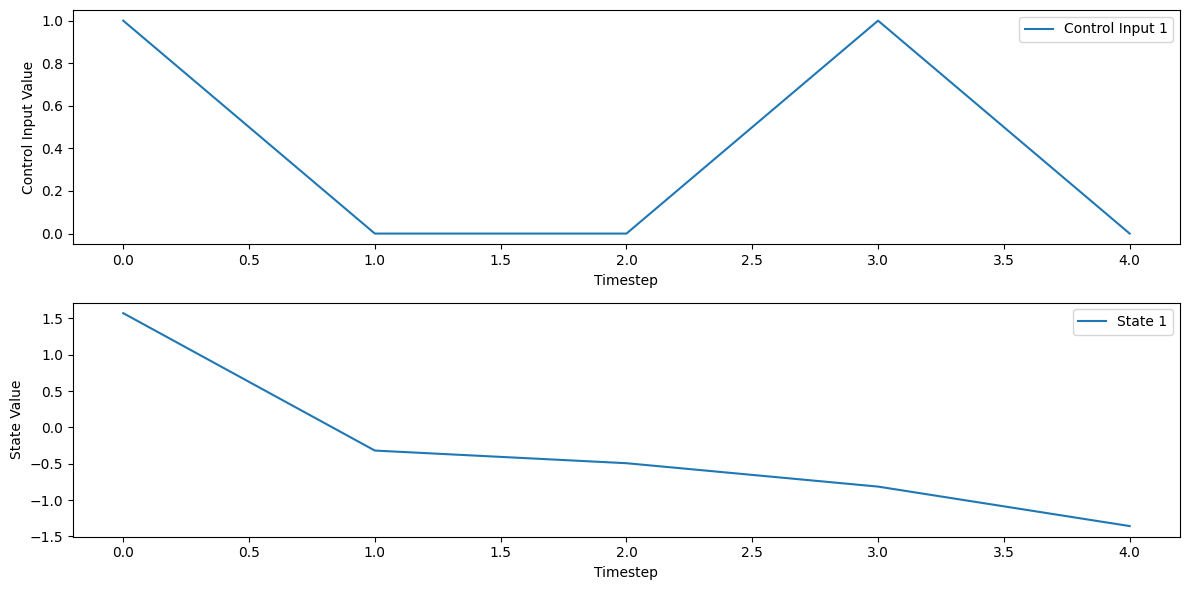

In [ ]:
rewards, control_inputs, states = evaluate(env, agent,1.5708)
# Assuming 'episode_idx' is the index of the chosen episode
episode_ctrl_inputs = control_inputs[0]
episode_states = states[0]
plt.figure(figsize=(12, 6))
# print(states[0])
# print(episode_states[:,0])
# Control input plot
plt.subplot(211)
# for dim in range(len(episode_ctrl_inputs)):  # Assuming multiple dimensions
plt.plot(episode_ctrl_inputs, label=f'Control Input {1}')
plt.xlabel('Timestep')
plt.ylabel('Control Input Value')
plt.legend()

# State plot (assuming multiple dimensions)
plt.subplot(212)
# for dim in range(len(episode_states[0])):
plt.plot(episode_states[:,2], label=f'State {1}')
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

plt.tight_layout()
plt.show()
